# Energiebedarf für Beleuchtung verschiedener Lichtfarbe abschätzen

## python konfigurieren

### Module importieren

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Circle
import pandas as pd
import datetime as dt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import sys
import os
import os.path
import platform
from PIL import Image
import requests
import scipy
from scipy.optimize import curve_fit
from IPython.display import Audio
from distutils.spawn import find_executable
from scipy.constants import h, c, k, sigma
import warnings
# sonst gibt es viele warnings
warnings.simplefilter('ignore')


print('Versionen der verwendeten python-Module: ')
print('numpy', np.__version__)
print('matplotlib', matplotlib.__version__)
print('pandas', pd.__version__)
print('datetime', dt)
print('seaborn', sns.__version__)
print('plotly', plotly.__version__)
print('sys', sys.version)
print('os', os)
print('platform', platform.__version__)
print('Image', Image.__version__)
print('requests', requests.__version__)
print('scipy', scipy.__version__)
#print('locale', locale)

Versionen der verwendeten python-Module: 
numpy 1.20.3
matplotlib 3.4.2
pandas 1.3.2
datetime <module 'datetime' from '/home/franzi/.pyenv/versions/miniconda3-latest/envs/21sye/lib/python3.9/datetime.py'>
seaborn 0.11.2
plotly 5.1.0
sys 3.9.6 (default, Aug 18 2021, 19:38:01) 
[GCC 7.5.0]
os <module 'os' from '/home/franzi/.pyenv/versions/miniconda3-latest/envs/21sye/lib/python3.9/os.py'>
platform 1.0.8
Image 8.3.1
requests 2.26.0
scipy 1.7.1


### Grafikparameter einstellen

In [2]:
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

if find_executable('latex'):
    plt.rcParams['text.usetex'] = True
    pd.set_option('display.latex.repr', True)
    pd.set_option('display.latex.longtable', True)

### Funktionen definieren

## Lernziele

<div class="admonition note" style="background: #e5f1ff; padding: 10px">
<div class="title"><b>LERNZIELE</b></div>
    <ul>
        <li> Lichtfarbe eines Leuchtmittels und Mindestenergiebedarf ermitteln</li>
        <li> mithilfe Theorie über Schwarzkörperstrahler </li>
        <li> um die Beleuchtungsqualität in Zusammenhang zu bringen mit dem Energiebedarf </li>
    </ul>
</div>

## Farbempfindlichkeit des menschlichen Auges

### Empfindlichkeit der Farbrezeptoren des menschlichen Auges

<a title="Torge Anders, CC BY-SA 3.0 &lt;http://creativecommons.org/licenses/by-sa/3.0/&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:CIE_Tristimul.png"><img width="512" alt="CIE Tristimul" src="https://upload.wikimedia.org/wikipedia/commons/c/c3/CIE_Tristimul.png"></a>

Das menschliche Auge nimmt anhand der Farbrezeptoren unterschiedliche Farben unterschiedlich stark wahr, rot gewichtet mit $\bar{x}$, grün gewichtet mit $\bar{y}$, blau gewichtet mit $\bar{z}$. Die zugehörige Theorie ist weitaus komplexer als das Diagramm erahnen lässt. Weiterführende Informationen finden sich z. B. in {cite:p}`wyman_simple_2013`.

### Formelmäßige Beschreibung der menschlichen Wahrnehmung

Das Signal am roten Farbrezeptor hat die Stärke $X$, das Signal am grünen Farbrezeptor die Stärke $Y$ und das Signal am blauen Farbrezeptor die Stärke $Z$. Je nach Einstrahlungsstärke $P(\lambda)$ bei einer Wellenlänge $\lambda$ ergibt sich damit {cite:p}`hill_converting_2016`:

\begin{equation}
X  = \int P(\lambda) \bar{x} d\lambda
\end{equation}

\begin{equation}
Y = \int P(\lambda) \bar{y} d\lambda
\end{equation}

\begin{equation}
Z = \int P(\lambda)\bar{z}d\lambda
\end{equation}

Interessiert man sich nicht für die Helligkeit, kann man diese Werte normieren und erhält die Chromatizität {cite:p}`hill_converting_2016`:

\begin{equation}
x = \frac{X}{X+Y+Z} , y = \frac{Y}{X+Y+Z}, z = \frac{Z}{X+Y+Z} = 1-x-y
\end{equation}

### Normfarbtafel

Die CIE-Normfarbtafel stellt den vom Menschen wahrnehmbaren dreidimensionalen Farbraum dar und zeigt den Zusammenhang zwischen $x$, $y$ und $z$ auf. Weiteres zur genauen Bedeutung erklärt auf grundlegende Weise [wikipedia](https://de.wikipedia.org/wiki/CIE-Normvalenzsystem), wo sich auch weiterführende Links befinden.

Die als Black-Body-Kurve bezeichnete Kurve zeigt auf, dass je nach Temperatur eines schwarzen Körpers eine andere Farbe betont wird - dies entspricht unserer Wahrnehmung das Licht einer hohen Farbtemperatur eher bläulicher und damit kälter wirkt und Licht einer niedrigen Farbtepmeratur eher rötlicher und damit wärmer wirkt.

<a title="Torge Anders, CC BY-SA 3.0 &lt;http://creativecommons.org/licenses/by-sa/3.0/&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:CIE-Normfarbtafel.png"><img width="512" alt="CIE-Normfarbtafel" src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/49/CIE-Normfarbtafel.png/512px-CIE-Normfarbtafel.png"></a>

Die $(x,y)$ Werte konvertiert ein Anzeigegerät in RGB Werte. Ein Farbsystem (im Diagramm ist beispielhaft Adobe RGB eingezeichnet) ist anhand von drei Punkten (Dreiecksecken) und dem Weißpunkt (Definition von Weiß im Dreieck) definiert {cite:p}`hill_converting_2016`:

\begin{equation}
\begin{pmatrix}
x_r & x_g & x_b\\
y_r & y_g & y_b\\
z_r & z_g & z_b
\end{pmatrix}
\cdot
\begin{pmatrix}r\\g\\b\end{pmatrix}=
\begin{pmatrix}x\\y\\z\end{pmatrix}
\end{equation}

### RGB-Werte errechnen

Stellt man die Gleichung um, erhält man mit der inversen Matrix die RGB Werte.

Nicht alle $(x,y)$ Werte sind im Dreieck (*gamut*) enthalten. Um negative Werte zu vermeiden (kein Anzeigegerät kann Licht verschlucken), kann man alle Werte gleichmäßig erhöhen, bis keiner mehr negativ ist {cite:p}`hill_converting_2016`.

Die Datei `../data/cie-cmf.txt` enthält die zugehörigen Daten für eine color matching function (CMF). Diese Datei und der Code stammen von {cite:p}`hill_converting_2016`.

In [3]:
# colour_system.py
import numpy as np

def xyz_from_xy(x, y):
    """Return the vector (x, y, 1-x-y)."""
    return np.array((x, y, 1-x-y))

class ColourSystem:
    """A class representing a colour system.

    A colour system defined by the CIE x, y and z=1-x-y coordinates of
    its three primary illuminants and its "white point".

    TODO: Implement gamma correction

    """

    # The CIE colour matching function for 380 - 780 nm in 5 nm intervals
    cmf = np.loadtxt('../data/cie-cmf.txt', usecols=(1,2,3))

    def __init__(self, red, green, blue, white):
        """Initialise the ColourSystem object.

        Pass vectors (ie NumPy arrays of shape (3,)) for each of the
        red, green, blue  chromaticities and the white illuminant
        defining the colour system.

        """

        # Chromaticities
        self.red, self.green, self.blue = red, green, blue
        self.white = white
        # The chromaticity matrix (rgb -> xyz) and its inverse
        self.M = np.vstack((self.red, self.green, self.blue)).T 
        self.MI = np.linalg.inv(self.M)
        # White scaling array
        self.wscale = self.MI.dot(self.white)
        # xyz -> rgb transformation matrix
        self.T = self.MI / self.wscale[:, np.newaxis]

    def xyz_to_rgb(self, xyz, out_fmt=None):
        """Transform from xyz to rgb representation of colour.

        The output rgb components are normalized on their maximum
        value. If xyz is out the rgb gamut, it is desaturated until it
        comes into gamut.

        By default, fractional rgb components are returned; if
        out_fmt='html', the HTML hex string '#rrggbb' is returned.

        """

        rgb = self.T.dot(xyz)
        if np.any(rgb < 0):
            # We're not in the RGB gamut: approximate by desaturating
            w = - np.min(rgb)
            rgb += w
        if not np.all(rgb==0):
            # Normalize the rgb vector
            rgb /= np.max(rgb)

        if out_fmt == 'html':
            return self.rgb_to_hex(rgb)
        return rgb

    def rgb_to_hex(self, rgb):
        """Convert from fractional rgb values to HTML-style hex string."""

        hex_rgb = (255 * rgb).astype(int)
        return '#{:02x}{:02x}{:02x}'.format(*hex_rgb)

    def spec_to_xyz(self, spec):
        """Convert a spectrum to an xyz point.

        The spectrum must be on the same grid of points as the colour-matching
        function, self.cmf: 380-780 nm in 5 nm steps.

        """

        XYZ = np.sum(spec[:, np.newaxis] * self.cmf, axis=0)
        den = np.sum(XYZ)
        if den == 0.:
            return XYZ
        return XYZ / den

    def spec_to_rgb(self, spec, out_fmt=None):
        """Convert a spectrum to an rgb value."""

        xyz = self.spec_to_xyz(spec)
        return self.xyz_to_rgb(xyz, out_fmt)

illuminant_D65 = xyz_from_xy(0.3127, 0.3291)
cs_hdtv = ColourSystem(red=xyz_from_xy(0.67, 0.33),
                       green=xyz_from_xy(0.21, 0.71),
                       blue=xyz_from_xy(0.15, 0.06),
                       white=illuminant_D65)

cs_smpte = ColourSystem(red=xyz_from_xy(0.63, 0.34),
                        green=xyz_from_xy(0.31, 0.595),
                        blue=xyz_from_xy(0.155, 0.070),
                        white=illuminant_D65)

cs_srgb = ColourSystem(red=xyz_from_xy(0.64, 0.33),
                       green=xyz_from_xy(0.30, 0.60),
                       blue=xyz_from_xy(0.15, 0.06),
                       white=illuminant_D65)

### Farbe von schwarzen Strahlern ermitteln

Der Code von {cite:p}`hill_converting_2016` berechnet damit nun für verschiedene schwarze Strahler die Farbtemperatur.

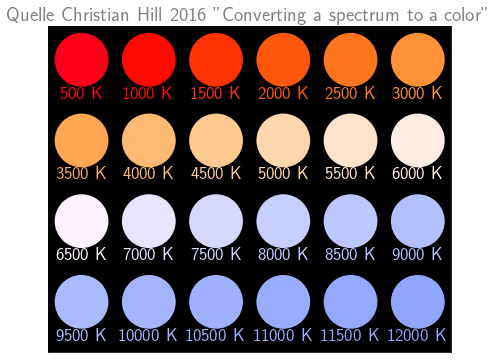

In [4]:
cs = cs_hdtv

def planck(lam, T):
    """ Returns the spectral radiance of a black body at temperature T.

    Returns the spectral radiance, B(lam, T), in W.sr-1.m-2 of a black body
    at temperature T (in K) at a wavelength lam (in nm), using Planck's law.

    """

    lam_m = lam / 1.e9
    fac = h*c/lam_m/k/T
    B = 2*h*c**2/lam_m**5 / (np.exp(fac) - 1)
    return B

fig, ax = plt.subplots()

# The grid of visible wavelengths corresponding to the grid of colour-matching
# functions used by the ColourSystem instance.
lam = np.arange(380., 781., 5)

for i in range(24):
    # T = 500 to 12000 K
    T = 500*i + 500

    # Calculate the black body spectrum and the HTML hex RGB colour string
    # it looks like
    spec = planck(lam, T)
    html_rgb = cs.spec_to_rgb(spec, out_fmt='html')

    # Place and label a circle with the colour of a black body at temperature T
    x, y = i % 6, -(i // 6)
    circle = Circle(xy=(x, y*1.2), radius=0.4, fc=html_rgb)
    ax.add_patch(circle)
    ax.annotate('{:4d} K'.format(T), xy=(x, y*1.2-0.5), va='center',
                ha='center', color=html_rgb)

# Set the limits and background colour; remove the ticks
ax.set_xlim(-0.5,5.5)
ax.set_ylim(-4.35, 0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('k')
ax.set_title('Quelle Christian Hill 2016 "Converting a spectrum to a color"', color='gray')
# Make sure our circles are circular!
ax.set_aspect("equal")
plt.show()

## Ermittlung des Energiebedarfs mithilfe der Methode des physikalischen Optimums

### Reale Strahlungsleistung

Wir betrachten eine beispielhafte "warme" LED-Leuchte aus {cite:p}`masoudinejad_data-sets_2020`, beschrieben in {cite:p}`masoudinejad_measurement_2016` und {cite:p}`masoudinejad_modeling_2020`.

Text(0.5, 1.0, 'Daten aus Masoudinejad 2020 "Data-sets for Indoor \nPhotovoltaic Behavior in Low Lighting condition"')

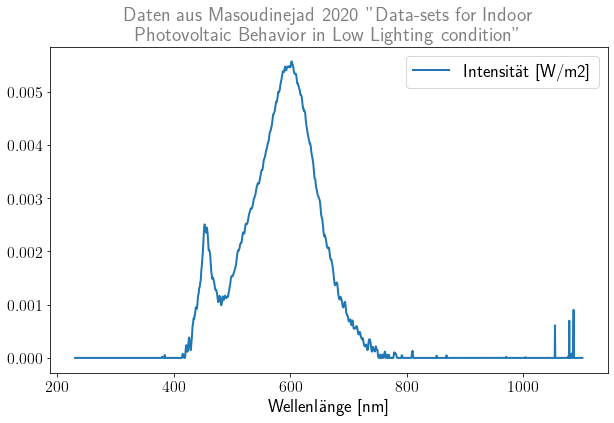

In [29]:
lamp = pd.read_csv('../data/Radiometry_Conrad_W_2991_2415.csv', names = ['Wellenlänge [nm]', 'Intensität [W/m2]'], skiprows=1)
lamp.plot(x = 'Wellenlänge [nm]', y= 'Intensität [W/m2]')
plt.title('Daten aus Masoudinejad 2020 "Data-sets for Indoor \nPhotovoltaic Behavior in Low Lighting condition"', color='gray')

Diese Strahlungsleistung misst ein Photovoltaikmodul, wenn es von der Leuchte angestrahlt wird.

### Elektrischer Bedarf der Leuchten

Um Beleuchtung professionell zu planen, benötigt man eine Lichtplanung. Dafür gibt es Programme wie [dialux](https://www.dial.de/dialux/) und [relux](https://relux.com/de/). Es gibt ganze Studiengänge, die Lichtdesign betrachten, vom Aufbau der Leuchten bis hin zum farbechten Ausleuchten der gewünschten Bereiche. Wichtig ist auf jeden Fall, dass man nicht einfach nur die elektrische Leistung und die Lichtausbeute eines Leuchtmittels betrachtet und dann die Beleuchtung austauscht, ohne auf die geometrischen Eigenschaften der Leuchtmittel zu achten.

Lastprofile für Beleuchtung abschätzen kann man folgendermaßen:
1. Prüfen Sie eine sinnvolle Beleuchtungsanordnung mit dialux oder relux (oben verlinkt), indem sie homogene Beleuchtung auf den relevanten Flächen anstreben.
2. Zählen Sie die Leuchten zusammen.
3. Erzeugen Sie anhand von Verhaltensprofilen Beleuchtungsbedarfe für jeden Zeitpunkt.
4. Erstellen Sie daraus das Beleuchtungslastprofil.
5. Plausibilisieren Sie mit Literaturwerten. Insbesondere LED-Beleuchtungen werden häufig "schön" gerechnet, indem Leuchten mit schlechter Farbwiedergabe eingesetzt werden. Dies ist auf Dauer für Anwender nicht angenehm und im Arbeitsumfeld nicht gesund. Es lohnt sich daher auch für die Betrachtung hier, eine etwas höher qualitative Leuchte anzunehmen, mit besserer Farbwiedergabe. So wird ihre Abschätzung realistischer.

Würde man genügend dieser Leuchten nebeneinander plazieren, um eine homogene Ausleuchtung mit diesem Spektrum bei einem Quadratmeter Fläche zu erreichen, so würde man die folgende optische Leistung erreichen:

In [30]:
print('optische Leistung pro qm '+str(lamp['Intensität [W/m2]'].sum())+' W/m2')

optische Leistung pro qm 1.5684140740034997 W/m2


Nun berücksichtigen wir, dass das menschliche Auge nur Wellenlängen zwischen 380 und 780 nm wahrnimmt {cite:p}`leifiphysik_sichtbares_2021` und ermitteln die Summe der Leistung für diesen Bereich.

In [39]:
visible = lamp['Intensität [W/m2]'].loc[(lamp['Wellenlänge [nm]'] >=380)&(lamp['Wellenlänge [nm]'] <=780)].sum()
print('sichtbare optische Leistung pro qm '+str(visible)+' W/m2')

sichtbare optische Leistung pro qm 1.5643943414716999 W/m2


Hinzu kommen die elektrischen Verluste. Leider beinhaltet der Datensatz keine Information darüber, wie viele Leuchten zu je 10 W verwendet wurden. Die optischen Verluste (Abstrahlung außerhalb des sichtbaren Bereichs) betragen:

In [40]:
print('optische Verluste pro qm '+str(lamp['Intensität [W/m2]'].sum()-visible)+' W/m2')

optische Verluste pro qm 0.00401973253179988 W/m2


oder

In [41]:
print('optische Verluste pro qm '+str((lamp['Intensität [W/m2]'].sum()-visible)/lamp['Intensität [W/m2]'].sum())+' %')

optische Verluste pro qm 0.002562928118554304 %


Die thermischen und elektrischen Verluste werden also deutlich überwiegen. Diese lassen sich mit der Information über die Leuchtenanzahl ermitteln.

Daraufhin lässt sich das physikalisch mögliche Optimierungspotenzial ermitteln.

- [ ] TODO Aus Masterprojekt HCL Daten einsetzen

```{bibliography}
:filter: docname in docnames
```